In [0]:
# 因為圖片實在太多，所以要用壓縮檔載入

import zipfile
f = zipfile.ZipFile("./drive/My Drive/AOI/train_images.zip")
f.extractall("./datasets")

In [2]:
# 讀答案

import pandas as pd

df = pd.read_csv("./drive/My Drive/AOI/train.csv")
df

,ID,Label
0,train_00000.png,0
1,train_00001.png,1
2,train_00002.png,1
3,train_00003.png,5
4,train_00004.png,5
...,...,...
2523,train_02523.png,0
2524,train_02524.png,0
2525,train_02525.png,3
2526,train_02526.png,0


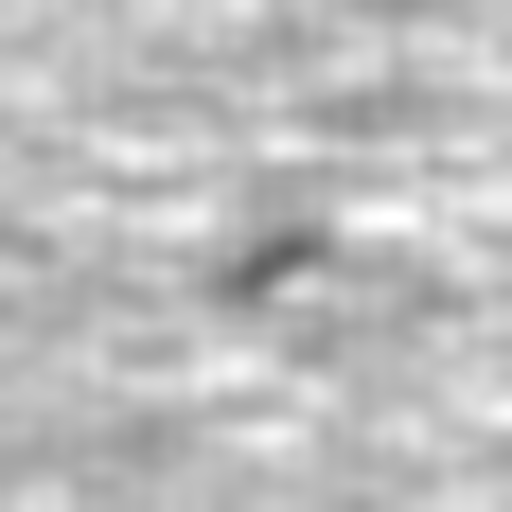

In [3]:
# 看一下

import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.preprocessing.image import load_img
import random

idx = random.randint(0, 2528)
img = load_img("./datasets/train_images/" + df["ID"][idx])

img

In [4]:
# 看shape的

print(img)

<PIL.Image.Image image mode=RGB size=512x512 at 0x7F71F0AE7908>


In [5]:
# cnn = VGG16

from tensorflow.keras.applications.vgg16 import VGG16

# 輸入照片不一樣大
# 所以要改長寬

# include_top = MLP = 關掉VGG16的MLP，後面在自己加。
# 所有照片改成 input_shape = (512, 512, 3) 的大小輸入。
cnn = VGG16(include_top=False, input_shape=(512, 512, 3))

cnn.layers

In [6]:
# Ver. Model

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization

for l in cnn.layers:
  # !!! trainable一定要先設置
  # !!! VGG16的權重我不想改變他
  l.trainable = False

# BatchNormalization() 一定要放在 Flatten() 前面
x = BatchNormalization()(cnn.output)
x = Flatten()(x)
# x = Dense(10240, activation="relu")(x)
x = Dense(1024, activation="relu")(x)
x = Dense(512, activation="relu")(x)
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)
out = Dense(6, activation="softmax")(x)

model2 = Model(inputs=cnn.input, outputs=out)
model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0     

In [0]:
# 優化器 - Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model2.compile(loss=SparseCategoricalCrossentropy(),
               optimizer="adam",
               metrics=["accuracy"])

In [8]:
# 切割 train and test
# 要用 np.array 才不容易出錯

import numpy as np
from sklearn.model_selection import train_test_split

# y的答案
label = df["Label"]

# 圖片, 圖片, 編號, 編號
x_train, x_test, y_train, y_test = train_test_split(np.array("./datasets/train_images/" + df["ID"]),
                                                    np.array(label),
                                                    test_size=0.1)

# 觀察區
# print(label)
print(np.array(label))
print(np.array(label).shape) ## (2528,)

print("")

GG = "./datasets/train_images/" + df["ID"]
print(np.array(GG))

[0 1 1 ... 3 0 5]
(2528,)

['./datasets/train_images/train_00000.png'
 './datasets/train_images/train_00001.png'
 './datasets/train_images/train_00002.png' ...
 './datasets/train_images/train_02525.png'
 './datasets/train_images/train_02526.png'
 './datasets/train_images/train_02527.png']


In [0]:
# 用 batch (批次) 訓練

from tensorflow.keras.applications.vgg16 import preprocess_input

# return = (原圖(batch), 預處理後的圖(batch), 答案(batch))

def dataflow (x_train, y_train, batch=20):
  idx = np.random.randint(0, x_train.shape[0], batch)
  x_batch, y_batch = x_train[idx], y_train[idx]

  x_ori, x_pre = [], []

  for fp in x_batch:
    img = load_img(fp, target_size=(512, 512))
    img_np = np.array(img)

    x_ori.append(img_np)

    img_pre = preprocess_input(img_np)
    x_pre.append(img_pre)
  
  x_ori, x_pre = np.array(x_ori), np.array(x_pre)
  
  return (x_ori, x_pre, y_batch)

In [10]:
# 訓練 - 這次不是 fit ...

# 訓練資料
# _, = 沒用到 -> 不想取名子
x_ori01, x_prepro01, y_batch01 = dataflow(x_train, y_train)
result1 = model2.train_on_batch(x_prepro01, y_batch01)  ## train on batch

# 驗證(<<<< verb.) 資料
x_ori02, x_prepro02, y_batch02 = dataflow(x_test, y_test)
result2 = model2.test_on_batch(x_prepro02, y_batch02)  ## test on batch

print("[Train]:", result1)
print("[valid]:", result2)

[Train]: [1.6688506603240967, 0.3499999940395355]
[valid]: [5.406707763671875, 0.44999998807907104]


In [11]:
# 訓練個 10 次
# 這個可以一直按 = 10 + 10 + 10 + ... + n 次 訓練

for i in range(10):
  print("-" * 10, "這是第", i+1, "次訓練")

  x_ori01, x_prepro01, y_batch01 = dataflow(x_train, y_train)
  result1 = model2.train_on_batch(x_prepro01, y_batch01)  ## train on batch
  
  # 驗證資料的 batch 要高點比較好
  x_ori02, x_prepro02, y_batch02 = dataflow(x_test, y_test, 50)
  result2 = model2.test_on_batch(x_prepro02, y_batch02)  ## test on batch

  print("[Train]:", result1)
  print("[valid]:", result2)

---------- 這是第 1 次訓練
[Train]: [10.672619819641113, 0.5]
[valid]: [14.897237777709961, 0.4399999976158142]
---------- 這是第 2 次訓練
[Train]: [13.455865859985352, 0.6000000238418579]
[valid]: [20.720287322998047, 0.36000001430511475]
---------- 這是第 3 次訓練
[Train]: [13.481742858886719, 0.6000000238418579]
[valid]: [22.66045570373535, 0.3400000035762787]
---------- 這是第 4 次訓練
[Train]: [5.504513740539551, 0.6499999761581421]
[valid]: [19.489633560180664, 0.36000001430511475]
---------- 這是第 5 次訓練
[Train]: [13.727384567260742, 0.6000000238418579]
[valid]: [13.385642051696777, 0.5400000214576721]
---------- 這是第 6 次訓練
[Train]: [5.7167205810546875, 0.5]
[valid]: [15.989296913146973, 0.3799999952316284]
---------- 這是第 7 次訓練
[Train]: [10.224218368530273, 0.3499999940395355]
[valid]: [17.68670654296875, 0.3400000035762787]
---------- 這是第 8 次訓練
[Train]: [5.434146404266357, 0.6499999761581421]
[valid]: [11.420757293701172, 0.5400000214576721]
---------- 這是第 9 次訓練
[Train]: [2.1305079460144043, 0.85000002384

In [12]:
# 拿 10% 的 200 張 算 evaluate = ['loss', 'acc']
timg, tx, ty = dataflow(x_test, y_test, 200)
model2.evaluate(tx, ty)

# 拿 10% 的驗證資料看機率值
pred = model2.predict(x_prepro02)
# pred

7/7 [==============================] - 2s 354ms/step - loss: 47.8697 - accuracy: 0.3150


In [0]:
# 載入 真．驗證資料

import zipfile
f = zipfile.ZipFile("./drive/My Drive/AOI/test_images.zip")
f.extractall("./datasets_test/")

In [14]:
# 讀 真．驗證資料 的答案

import pandas as pd

df2 = pd.read_csv("./drive/My Drive/AOI/test.csv")
df2

,ID,Label
0,test_00000.png,NaN
1,test_00001.png,NaN
2,test_00002.png,NaN
3,test_00003.png,NaN
4,test_00004.png,NaN
...,...,...
10137,test_10137.png,NaN
10138,test_10138.png,NaN
10139,test_10139.png,NaN
10140,test_10140.png,NaN


In [15]:
# 來預言喔

# 1: 讀圖片

import glob
path = glob.glob("datasets_test/test_images/*")
# print(path)

# 按名稱排序
path = sorted(path)

# 2: 路徑轉成np.array
npPath = np.array(path)
print(npPath)

['datasets_test/test_images/test_00000.png'
 'datasets_test/test_images/test_00001.png'
 'datasets_test/test_images/test_00002.png' ...
 'datasets_test/test_images/test_10139.png'
 'datasets_test/test_images/test_10140.png'
 'datasets_test/test_images/test_10141.png']


In [0]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img

def dataflow2(npPath):

  AA = []

  for i, fp in enumerate(npPath):
    img = load_img(fp, target_size=(512, 512))

    img_np = np.array(img)

    img_pre = preprocess_input(img_np)
    AA.append(img_pre)

  K = np.array(AA)
    
  return i, K

In [17]:
seq01 = 0
seq02 = 1001

K = npPath[seq01:seq02]
i, K = dataflow2(K)

index_pre = model2.predict(K).argmax(axis=-1)
index_pre

array([1, 3, 1, ..., 3, 1, 3])

In [0]:
# ^^^^^^^^^^^^
# colab的ram一直爆炸，我決定重寫。

In [19]:
pre_df = pd.DataFrame({"機器預測":index_pre})

pre_df

,機器預測
0,1
1,3
2,1
3,1
4,3
...,...
996,1
997,3
998,3
999,1


In [20]:
df2 = df2.drop(["Label"], axis=1)

result = pd.concat([df2, pre_df], axis=1) 
result[0:1001]

,ID,機器預測
0,test_00000.png,1.0
1,test_00001.png,3.0
2,test_00002.png,1.0
3,test_00003.png,1.0
4,test_00004.png,3.0
...,...,...
996,test_00996.png,1.0
997,test_00997.png,3.0
998,test_00998.png,3.0
999,test_00999.png,1.0


In [0]:
# ^^^^^^^^^^^^
# 模型的ram一直掛掉，我覺得應該要寫個新版。